# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Clustering](#Clustering)
    - [4-Seam](#4-Seam-Fastball)
    - [Cutter](#Cutter)
    - [Sinker](#Sinker)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)
- [Linear Regression Modeling](#Linear-Regression-Modeling)
    - [4-Seam](#Linear-Regression---4-Seam)
    - [Cutter](#Linear-Regression---Cutter)
    - [Sinker](#Linear-Regression---Sinker)
    - [Slider](#Linear-Regression---Slider)
    - [Curveball](#Linear-Regression---Curveball)
    - [Changeup](#Linear-Regression---Changeup)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(116889, 29)


,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,stand,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,R,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
4,L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,L,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0
9,R,SI,94.3,1982.0,221.0,16.20,10.56,21.018028,94.4,-1.20,6.05,6.5,53.98,0.26,-0.26,1.78,0,-0.061,R,140.0,75.3,65.0,3.0,0.000,0.000,0.0,1.0,0.0,0.0
18,R,SL,90.5,2133.0,216.0,-0.12,7.44,23.569061,91.1,-1.51,5.93,6.3,54.23,-0.01,0.01,2.23,0,-0.173,L,294.0,96.8,18.0,4.0,0.409,0.457,0.0,1.0,0.0,0.0
27,R,FF,94.9,2224.0,216.0,9.00,14.16,23.435195,95.5,-2.71,6.38,6.6,53.86,0.10,-0.10,1.94,0,-0.163,R,308.0,91.8,29.0,3.0,0.109,0.156,0.0,1.0,0.0,0.0


In [3]:
# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

# Drop pitch types Knuckle Curve and Splitter
# pitch = pitch[(pitch['pitch_type'] != 'KC') & (pitch['pitch_type'] != 'FS')]

Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

### Multicolinearity - VIF

In [4]:
# features = data[['velo', 'release_extension', 'pfx_-x', 'pfx_z', 
#                  'release_pos_x', 'release_pos_z', 'xba' 'launch_speed_angle']]

In [5]:
features = data[['velo', 'spin_rate', 'pfx_-x', 'pfx_z', 'release_pos_z', 'release_extension', 'delta_run_exp']]
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(7)

,feature,VIF
6,delta_run_exp,1.010745
2,pfx_-x,1.128651
3,pfx_z,3.078484
1,spin_rate,53.496874
4,release_pos_z,97.701118
5,release_extension,150.509848
0,velo,262.248636


# Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Vertical Release Position, Release Extension

**Dependent Variable:** delta_run_exp

In [6]:
features = data[['velo', 'spin_rate', 'pfx_-x', 'pfx_z', 'release_pos_z', 
                 'release_extension', 'delta_run_exp', 'pitch_type']]

ff = features.loc[features['pitch_type'] == 'FF']
print('4-Seam shape:', ff.shape)
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)

4-Seam shape: (40378, 8)
Cutter shape: (8698, 8)
Sinker shape: (21979, 8)
Slider shape: (21518, 8)
Curveball shape: (8439, 8)
Changeup shape: (15877, 8)


# Clustering

## 4-Seam

In [7]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca_ff = PCA().fit_transform(X_ff_scaled)
model_ff = pd.DataFrame(data = pca_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print('Predicted clusters to points: ', label_ff[:10], '\n')

Number of iterations: 17
Number of features: 7
Number of clusters: 2
Inertia: 244090.96374058124 

Predicted clusters to points:  [0 0 1 1 1 1 0 0 1 0] 



### Cluster Labels - 4-Seam

In [8]:
X_ff['label'] = label_ff
model_ff['label'] = label_ff

X_ff.groupby(by = 'label').mean().T

label,0,1
velo,91.904849,94.794038
spin_rate,2171.733909,2325.738198
pfx_-x,-2.683929,6.872135
pfx_z,14.848972,16.321762
release_pos_z,5.932507,5.916368
release_extension,6.239005,6.454757
delta_run_exp,0.067653,0.060313


## Cutter

In [9]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca_fc = PCA().fit(X_fc_scaled)
principal_components_fc = pca_fc.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 14
Number of features: 7
Number of clusters: 2
Inertia: 52063.57943624956 

Predicted clusters to points:  [0 0 1 1 1 1 0 1 0 0] 



### Cluster Labels - Cutter

In [10]:
X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
velo,89.600617,87.343456
spin_rate,2484.459530,2239.993980
pfx_-x,-3.982502,1.314622
pfx_z,7.248422,8.405191
release_pos_z,6.064583,5.754856
release_extension,6.228246,6.279041
delta_run_exp,0.039380,0.057610


## Sinker

In [11]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 13
Number of features: 7
Number of clusters: 2
Inertia: 129874.55713080542 

Predicted clusters to points:  [1 1 1 1 1 1 0 0 0 0] 



### Cluster Labels - Sinker

In [12]:
X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
velo,90.754346,94.287150
spin_rate,2006.398387,2183.391501
pfx_-x,-3.089429,11.261947
pfx_z,6.464195,10.381865
release_pos_z,5.501795,5.869158
release_extension,6.199506,6.350516
delta_run_exp,0.039361,0.026904


## Slider

In [13]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 13
Number of features: 7
Number of clusters: 2
Inertia: 129635.11354217607 

Predicted clusters to points:  [0 0 1 1 1 1 1 0 0 0] 



### Cluster Labels - Slider

In [14]:
X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
velo,85.506408,82.730376
spin_rate,2323.838696,2572.619329
pfx_-x,0.000939,-9.995068
pfx_z,2.644816,-0.167824
release_pos_z,5.946216,5.508871
release_extension,6.213633,6.321388
delta_run_exp,0.073482,0.062565


## Curveball

In [15]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 34
Number of features: 7
Number of clusters: 2
Inertia: 50927.75515683573 

Predicted clusters to points:  [1 1 1 0 1 1 1 1 1 1] 



### Cluster Labels - Curveball

In [16]:
X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
velo,79.629211,77.651465
spin_rate,2324.647607,2646.620026
pfx_-x,-1.103690,-6.290791
pfx_z,-3.950872,-12.642370
release_pos_z,5.882890,6.051874
release_extension,6.171772,6.213708
delta_run_exp,0.086969,0.065237


## Changeup

In [17]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch)
principal_components_ch = pca.transform(X_ch)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 2
Number of features: 7
Number of clusters: 2
Inertia: 494513348.9966824 

Predicted clusters to points:  [0 0 1 0 0 0 0 1 1 1] 



### Cluster Labels - Changeup

In [18]:
X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
velo,84.396484,85.084289
spin_rate,1557.389120,2035.577359
pfx_-x,2.491379,3.363161
pfx_z,6.698644,7.265949
release_pos_z,5.844533,5.743621
release_extension,6.344986,6.201054
delta_run_exp,0.048169,0.038132


# Linear Regression Modeling

## Linear Regression - 4-Seam

Velocity, Spin Rate, HB, VB, Release Extension, Verical Release Position

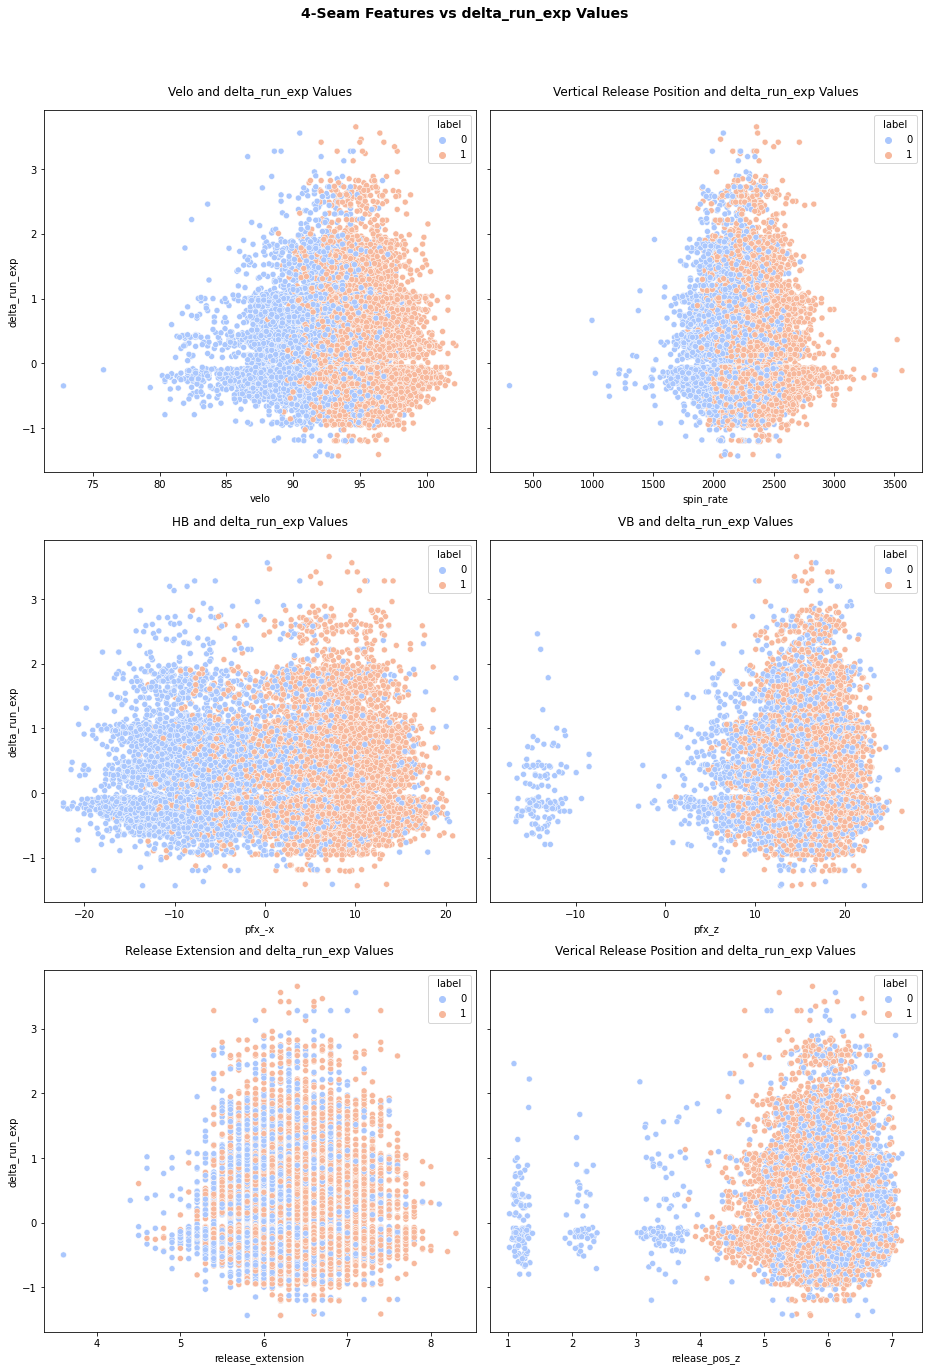

In [19]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('4-Seam Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_ff, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_ff, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_ff, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_ff, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_ff, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_ff, x = 'release_pos_z', y = 'delta_run_exp', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [20]:
X = X_ff.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff['delta_run_exp']

ols_ff = sm.OLS(y, X).fit()
pred_ff = ols_ff.predict(X)
fitted_vals_ff = ols_ff.fittedvalues
residuals_ff = ols_ff.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
print(ols_ff.summary())

MSE: 0.2967
RMSE: 0.5447
MAE: 0.4198
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.969
Date:                Wed, 02 Mar 2022   Prob (F-statistic):             0.0552
Time:                        15:34:59   Log-Likelihood:                -32762.
No. Observations:               40378   AIC:                         6.554e+04
Df Residuals:                   40370   BIC:                         6.561e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

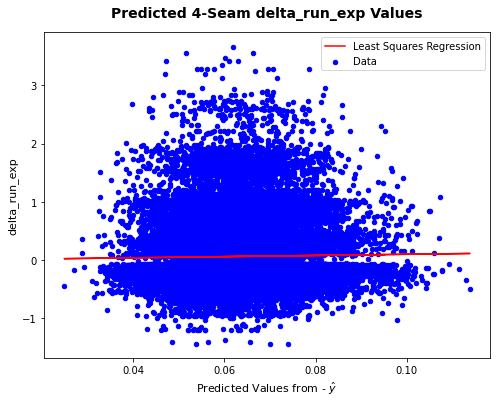

In [21]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff, np.poly1d(np.polyfit(pred_ff, y, 1))(pred_ff), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted 4-Seam delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);

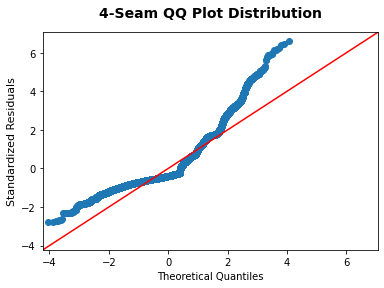

In [22]:
sm.qqplot(residuals_ff, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

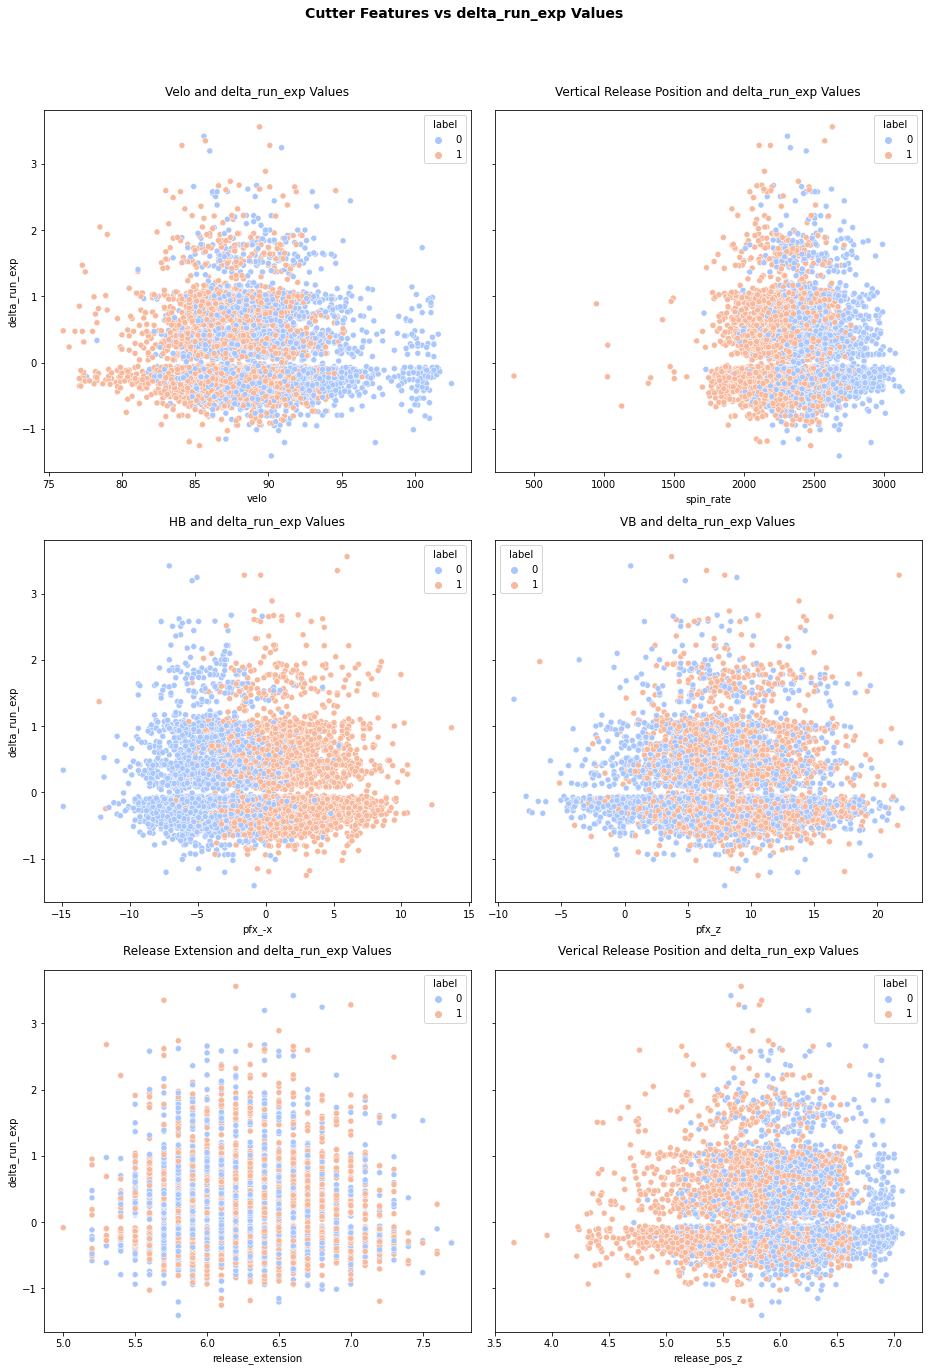

In [23]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('Cutter Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_fc, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_fc, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_fc, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_fc, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_fc, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_fc, x = 'release_pos_z', y = 'delta_run_exp', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [24]:
X = X_fc.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc['delta_run_exp']

ols_fc = sm.OLS(y, X).fit()
pred_fc = ols_fc.predict(X)
fitted_vals_fc = ols_fc.fittedvalues
residuals_fc = ols_fc.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc), 4))
print(ols_fc.summary())

MSE: 0.2994
RMSE: 0.5472
MAE: 0.4192
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.105
Date:                Wed, 02 Mar 2022   Prob (F-statistic):              0.357
Time:                        15:35:02   Log-Likelihood:                -7097.0
No. Observations:                8698   AIC:                         1.421e+04
Df Residuals:                    8690   BIC:                         1.427e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

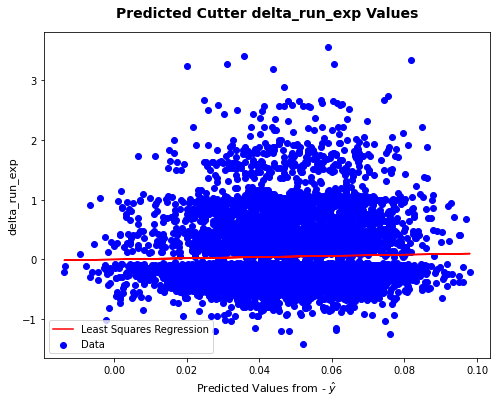

In [25]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc, np.poly1d(np.polyfit(pred_fc, y, 1))(pred_fc), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted Cutter delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);

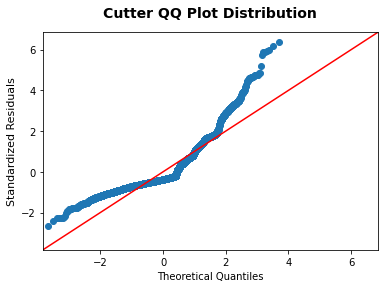

In [26]:
sm.qqplot(residuals_fc, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

ValueError: Could not interpret value `xwodelta_run_expbacon` for parameter `y`

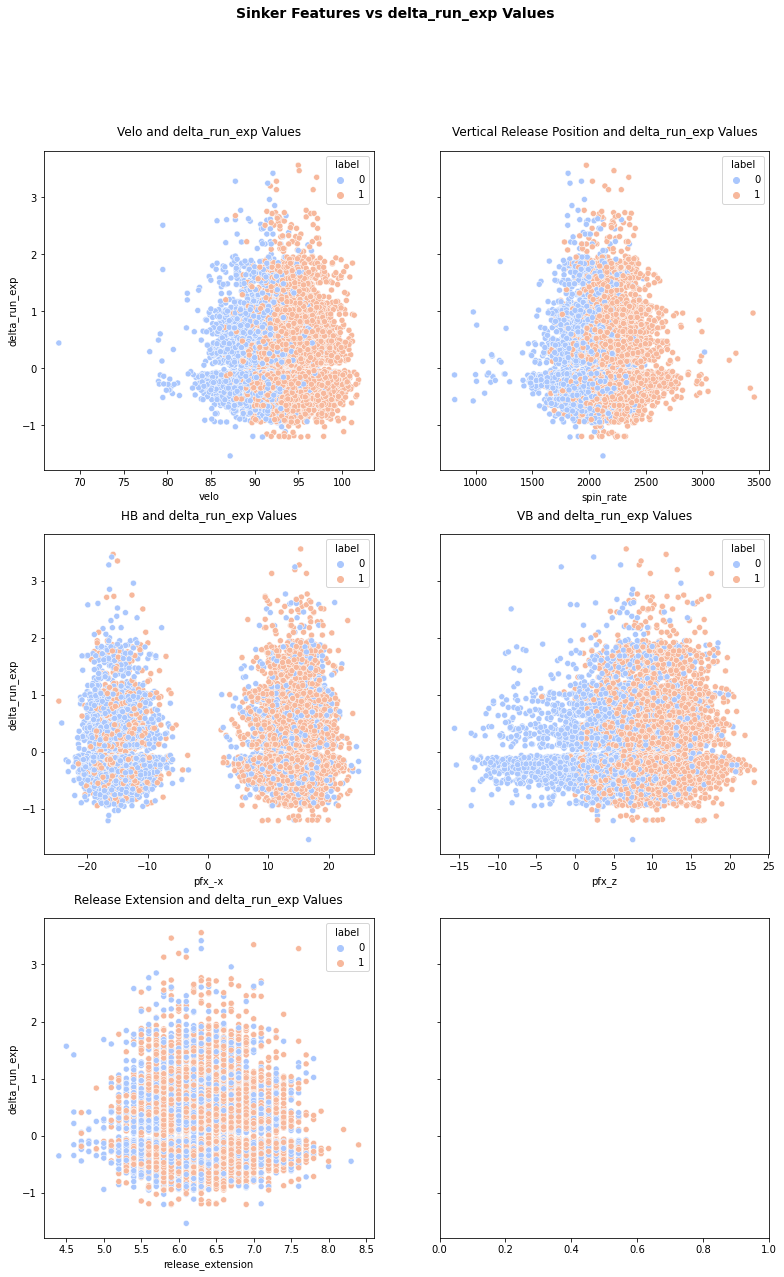

In [27]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('Sinker Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_si, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_si, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_si, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_si, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_si, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_si, x = 'release_pos_z', y = 'xwodelta_run_expbacon', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [ ]:
X = X_si.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si['delta_run_exp']

ols_si = sm.OLS(y, X).fit()
pred_si = ols_si.predict(X)
fitted_vals_si = ols_si.fittedvalues
residuals_si = ols_si.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))
print(ols_si.summary())

In [ ]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si, np.poly1d(np.polyfit(pred_si, y, 1))(pred_si), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted Sinker delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);
print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))

In [ ]:
sm.qqplot(residuals_si, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('Slider Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_sl, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_sl, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_sl, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_sl, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_sl, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_sl, x = 'release_pos_z', y = 'delta_run_exp', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [ ]:
X = X_sl.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl['delta_run_exp']

ols_sl = sm.OLS(y, X).fit()
pred_sl = ols_sl.predict(X)
fitted_vals_sl = ols_sl.fittedvalues
residuals_sl = ols_sl.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl), 4))
print(ols_sl.summary())

In [ ]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl, np.poly1d(np.polyfit(pred_sl, y, 1))(pred_sl), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted Slider delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [ ]:
sm.qqplot(residuals_sl, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('Curveball Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_cu, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_cu, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_cu, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_cu, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_cu, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_cu, x = 'release_pos_z', y = 'delta_run_exp', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [ ]:
X = X_cu.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu['delta_run_exp']

ols_cu = sm.OLS(y, X).fit()
pred_cu = ols_cu.predict(X)
fitted_vals_cu = ols_cu.fittedvalues
residuals_cu = ols_cu.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu), 4))
print(ols_cu.summary())

In [ ]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu, np.poly1d(np.polyfit(pred_cu, y, 1))(pred_cu), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted Curveball delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [ ]:
sm.qqplot(residuals_cu, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (13, 20), sharey = True)
fig.suptitle('Changeup Features vs delta_run_exp Values', fontsize = 14, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0], data = X_ch, x = 'velo', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[0][0].set_title('Velo and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_ch, x = 'spin_rate', y = 'delta_run_exp',hue='label',palette='coolwarm')
axs[0][1].set_title('Vertical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][0], data = X_ch, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][0].set_title('HB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[1][1], data = X_ch, x = 'pfx_z', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
axs[1][1].set_title('VB and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][0], data = X_ch, x = 'release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
axs[2][0].set_title('Release Extension and delta_run_exp Values', fontsize = 12, pad = 15)
sns.scatterplot(ax = axs[2][1], data = X_ch, x = 'release_pos_z', y = 'delta_run_exp', hue='label',palette='coolwarm')
axs[2][1].set_title('Verical Release Position and delta_run_exp Values', fontsize = 12, pad = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [ ]:
X = X_ch.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ch['delta_run_exp']

ols_ch = sm.OLS(y, X).fit()
pred_ch = ols_ch.predict(X)
fitted_vals_ch = ols_ch.fittedvalues
residuals_ch = ols_ch.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch), 4))
print(ols_ch.summary())

In [ ]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch, np.poly1d(np.polyfit(pred_ch, y, 1))(pred_ch), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('delta_run_exp', fontsize = 11)
plt.title('Predicted Changeup delta_run_exp Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [ ]:
sm.qqplot(residuals_ch, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);